# Random Forest


## Imports


In [1]:
import util
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
NUM_FOLDS = 10


## Read the data


### Train Data


In [2]:
X, y = util.getData(path='../data/train_data.csv', scaleNumericalFeatures=True)

# create a new column called weightOverHeightSquared
# X['weightOverHeightSquared'] = X['Weight'] / X['Height'] ** 2

X = X[['Weight', 'Height']]


### Validation Data


In [3]:
# Divide the train data into training and validation
X_train = X[:int(0.8 * len(X))]
y_train = y[:int(0.8 * len(y))]
X_val = X[int(0.8 * len(X)):]
y_val = y[int(0.8 * len(y)):]


### Test Data


In [4]:
X_test, y_test = util.getData(
    path='../data/train_data.csv', scaleNumericalFeatures=True)

# create a new column called weightOverHeightSquared
# X_test['weightOverHeightSquared'] = X_test['Weight'] / X_test['Height'] ** 2

# X_test = X_test[['Weight', 'Height']]


## Train the model


In [5]:
clf = RandomForestClassifier(
    n_estimators=50, max_depth=20, min_samples_split=2)
clf.fit(X, y)
cv_results = cross_validate(clf, X, y, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())
print('f1_weighted: ', cv_results['test_f1_weighted'].mean())


accuracy:  0.9796681384418175
f1_macro:  0.9716614615498965
f1_micro:  0.9796681384418175
f1_weighted:  0.9795537527487103


## Model Analysis


### Feature Importance Plot

A feature importance plot shows the importance of each feature in the model. It can be used to identify the most important features and to understand the impact of each feature on the model's predictions.


  feature  importance
0  Weight    0.810101
1  Height    0.189899


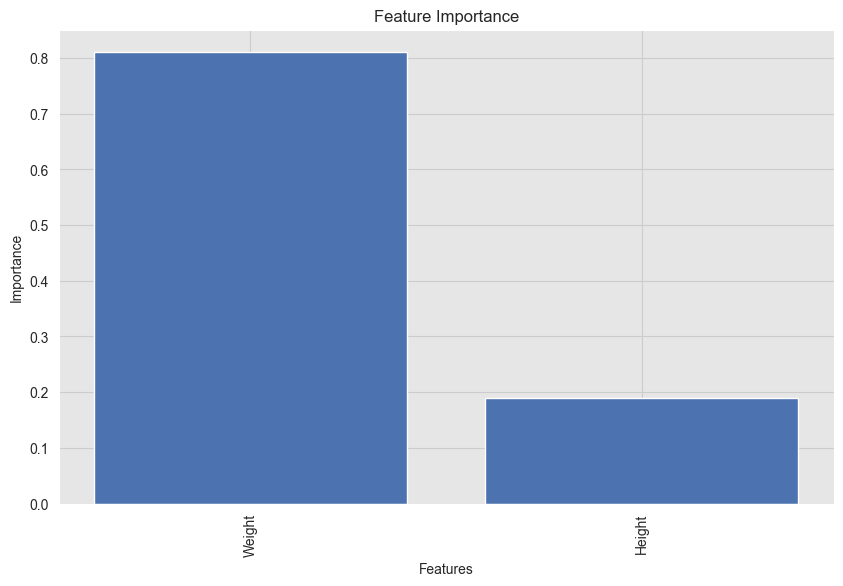

In [6]:
# Get the feature importance
importance = clf.feature_importances_

feature_importance = util.getFeatureImportance(
    features=X.columns, importance=importance)
print(feature_importance)

plt = util.getFeatureImportancePlot(
    feature_importance, modelname='Random Forest')
plt.show()


### Learning Curves Plot

show the training error (Ein) and validation error (Eval) as a function of the training set size


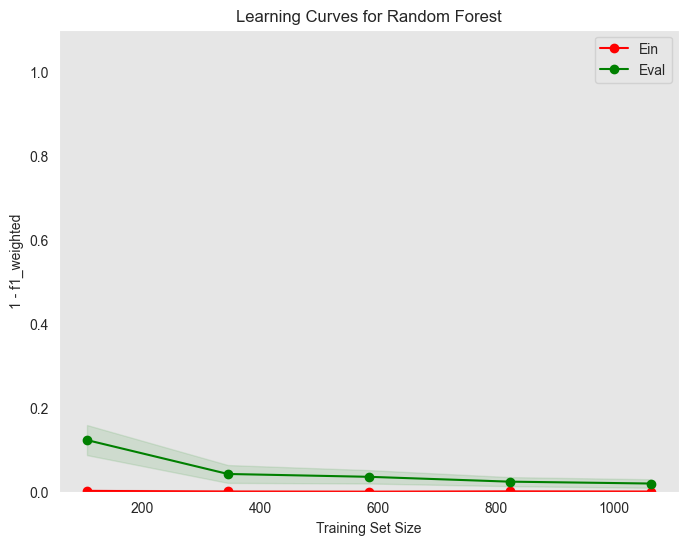

In [7]:
plt = util.getLearningCurvePlot(estimator=RandomForestClassifier(
    n_estimators=30, max_depth=10, min_samples_split=2), X=X, y=y, cv=NUM_FOLDS, modelname='Random Forest')
plt.show()


### Partial Dependence Plot:

A partial dependence plot shows the relationship between a feature and the model's predictions while holding all other features constant. It can be used to understand the impact of a single feature on the model's predictions i.e. PDPs show the average effect on predictions as the value of feature changes.

From the plots, we may see the type of the relationship between a feature and a prediction. Some relationships may look linear whereas other are more complex.


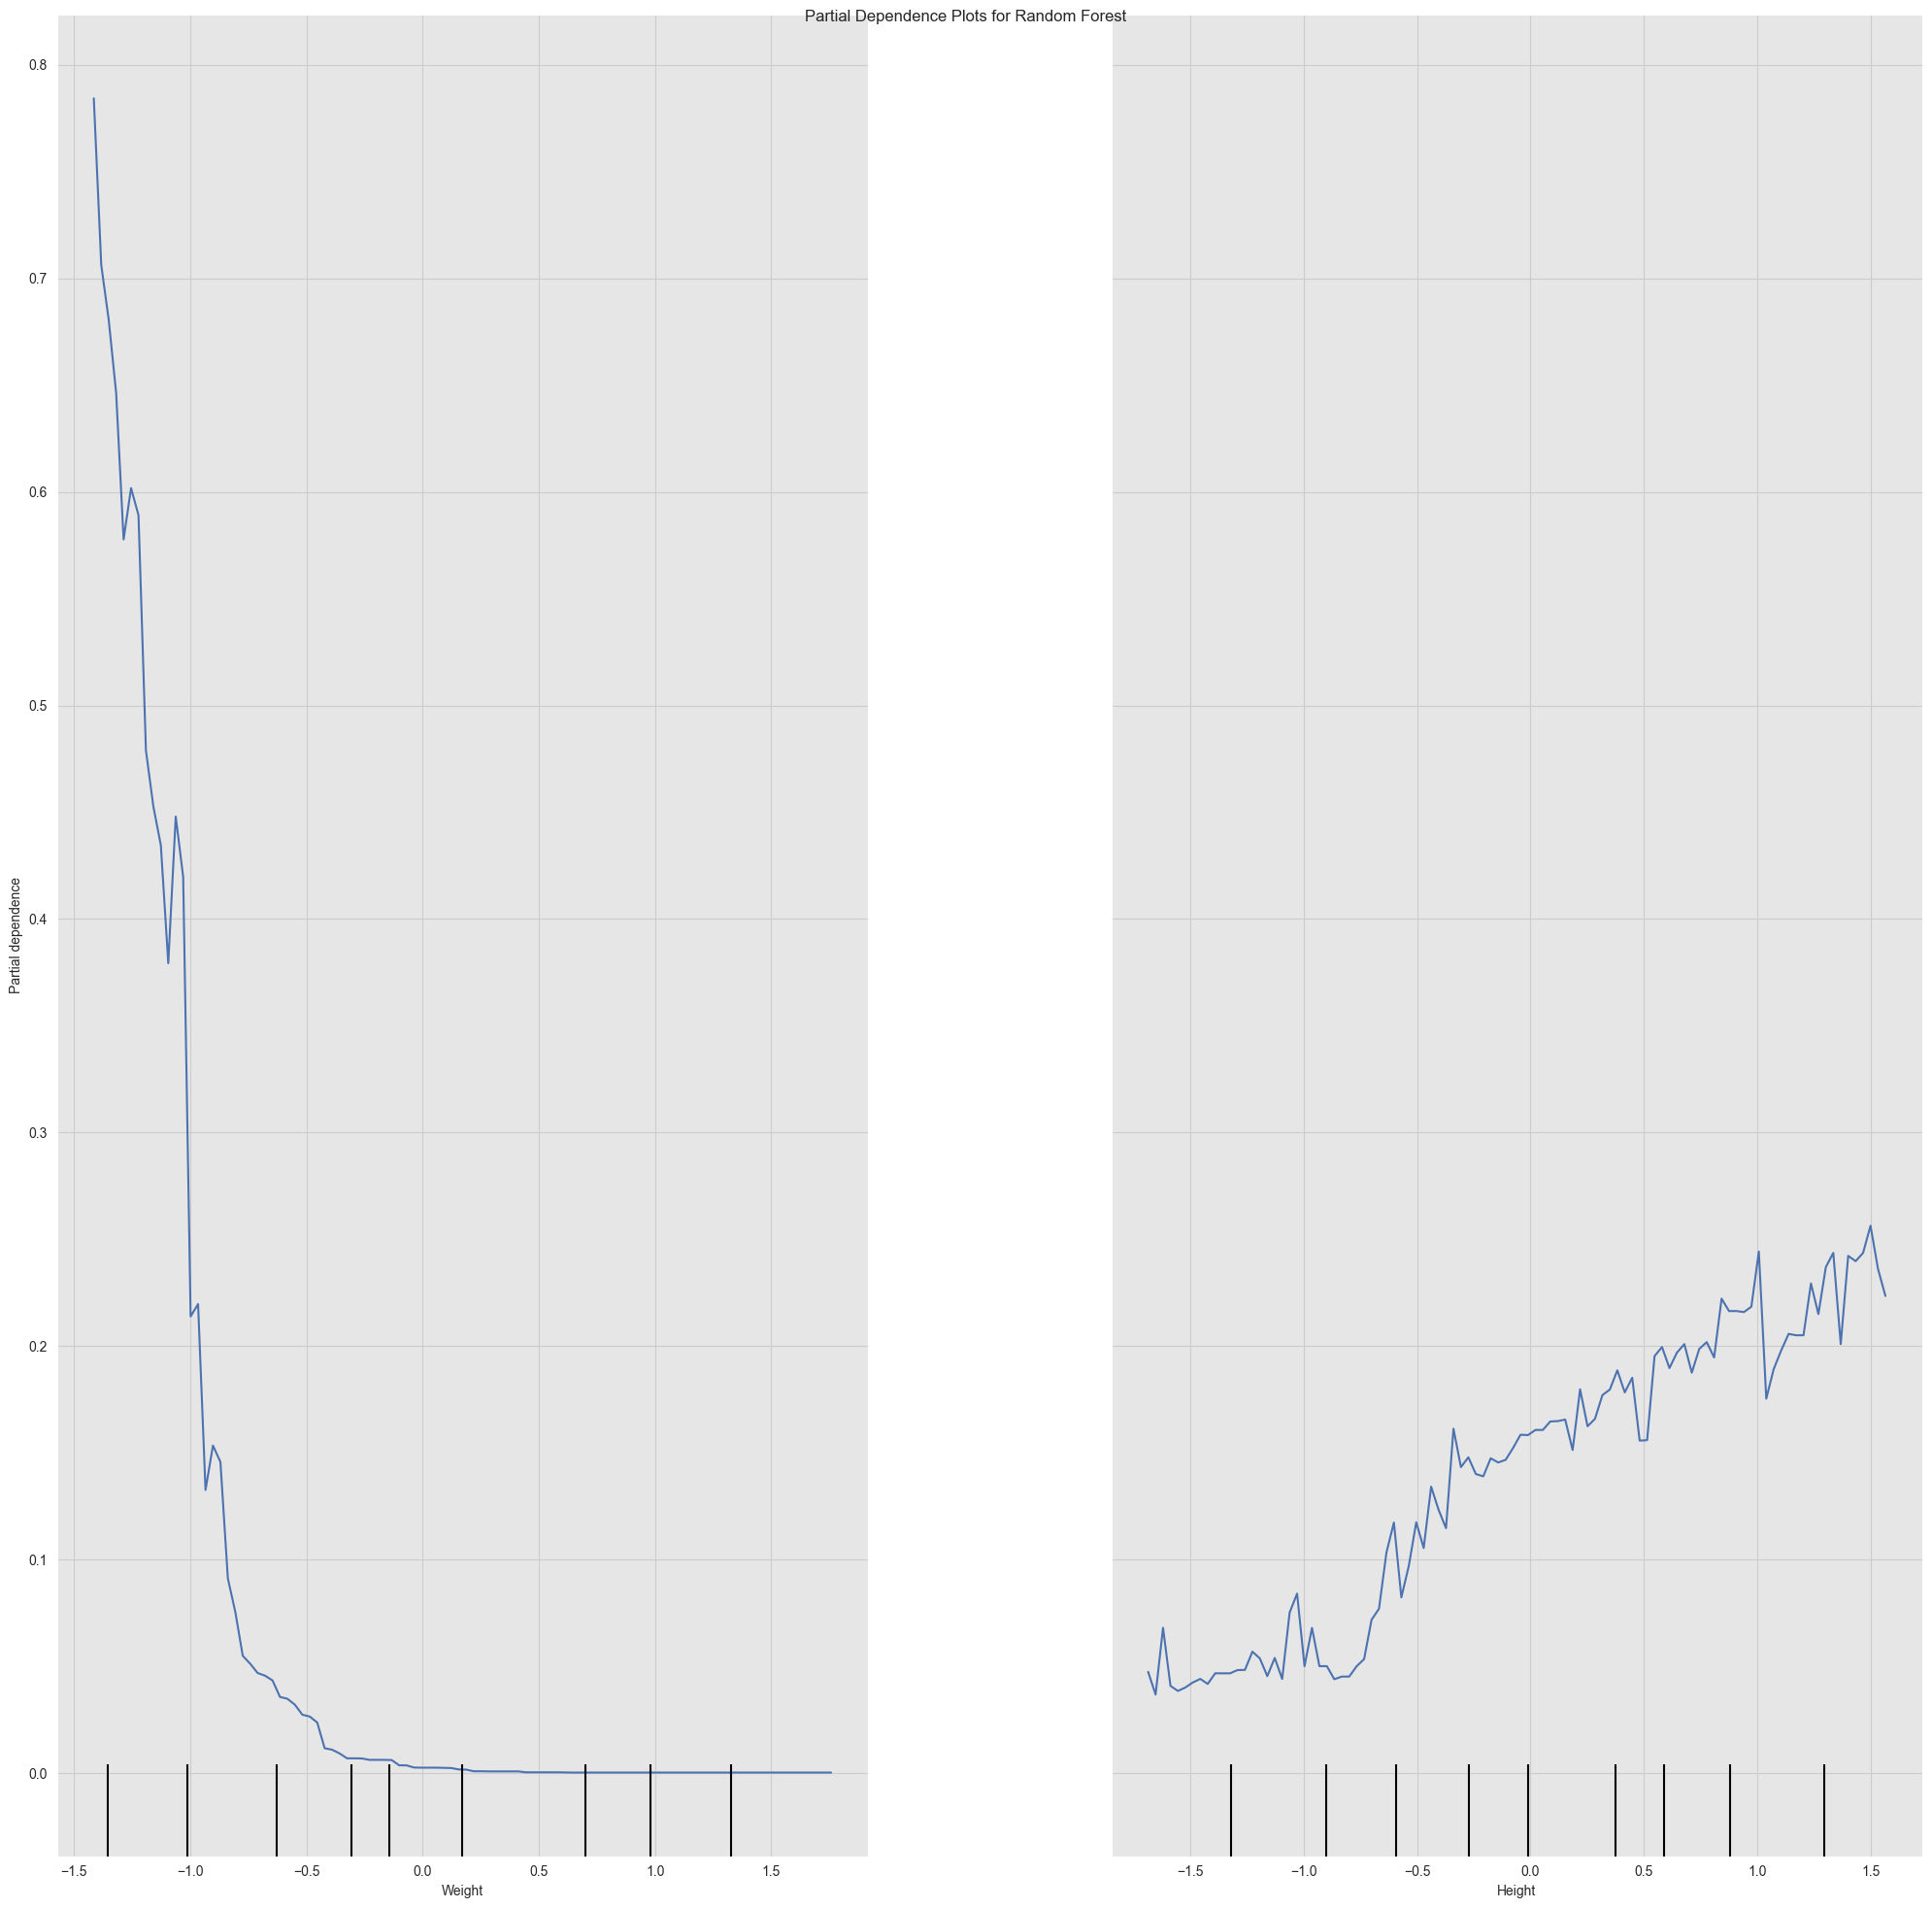

In [8]:
plt = util.getPartialDependenciesPlot(clf, X, modelname='Random Forest')
plt.show()


### Hyperparameter Tuning

This is a process of adjusting the parameters of a model to optimize its performance. It can be done using techniques like grid search, random search, or Bayesian optimization.


In [9]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [5, 10, 20, 50, 100],
    'max_depth': [10, 20, 50, 100, 500],
    'min_samples_split': [2, 5, 10]
}


### Grid Search


In [10]:
grid_search = util.getGridSearch(estimator=RandomForestClassifier(
), param_grid=param_grid, X=X_train, y=y_train, cv=NUM_FOLDS, scoring='f1_weighted')
# Print the results
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print("Test score with best parameters:", grid_search.score(X_val, y_val))


Best parameters found: {'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 20}
Best score found: 0.9809438247080088
Test score with best parameters: 0.9740420496191159


### Heatmap


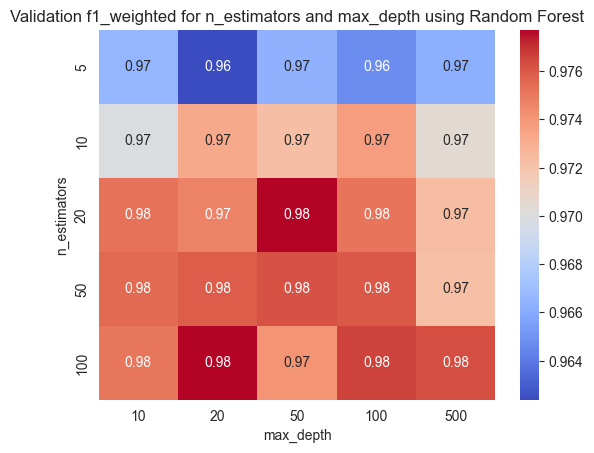

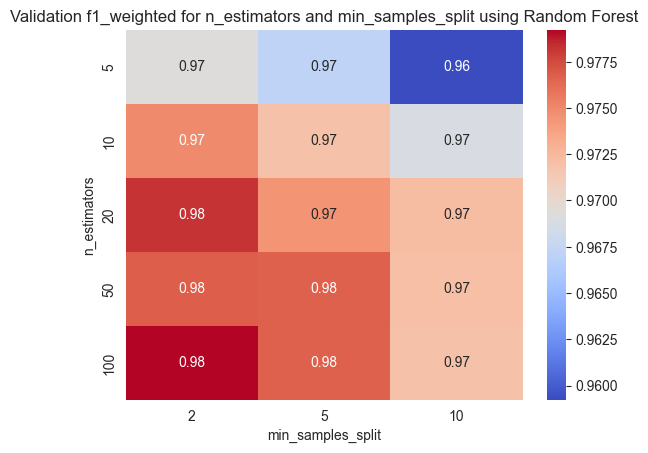

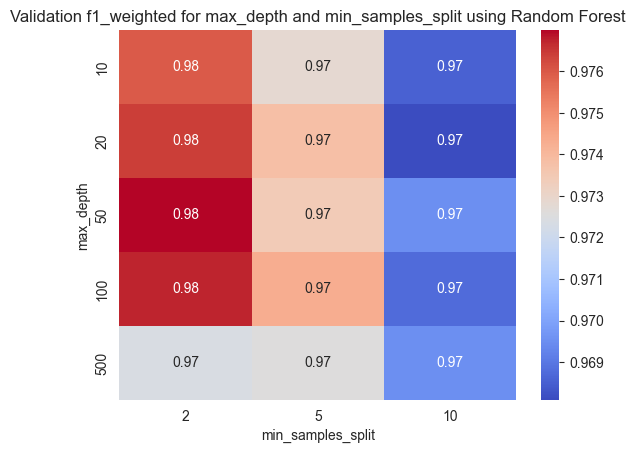

In [11]:
util.plotHyperParamHeatMaps(param_grid, grid_search, modelname='Random Forest')


### Train-Validation Curve


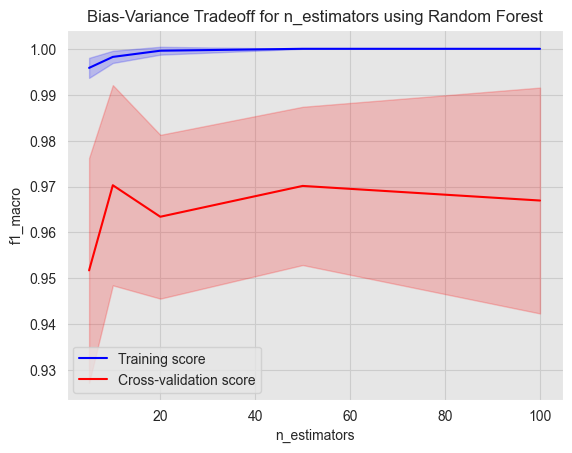

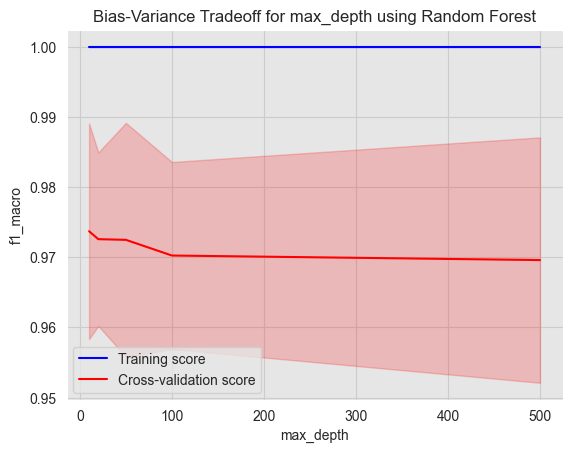

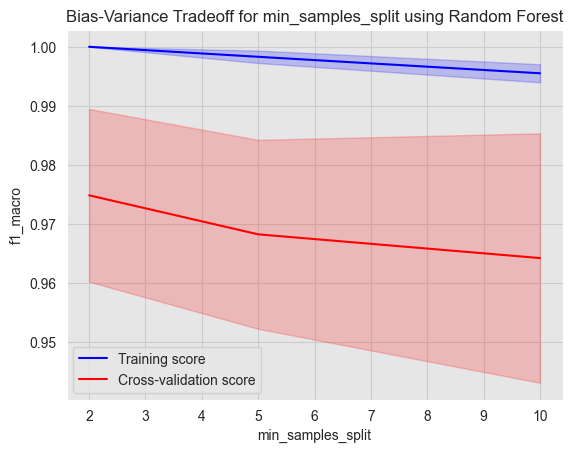

In [12]:

util.plotHyperParamTrainValidationCurve(estimator=RandomForestClassifier(
), param_grid=param_grid, X=X_train, y=y_train, cv=NUM_FOLDS, scoring='f1_macro', modelname='Random Forest')


## Bias-Variance Analysis


In [13]:

clf = RandomForestClassifier(
    n_estimators=100, max_depth=50, min_samples_split=2)

mse, bias, var = util.getBiasVariance(
    clf, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val)


In [14]:
print("mse: ", mse)
print("bias: ", bias)
print("var: ", var)


mse:  0.027552742616033753
bias:  0.019023417721518984
var:  0.00852932489451477


### Tree Plot

A tree plot shows the structure of the decision trees used in the random forest. It can be used to understand how the model makes predictions.


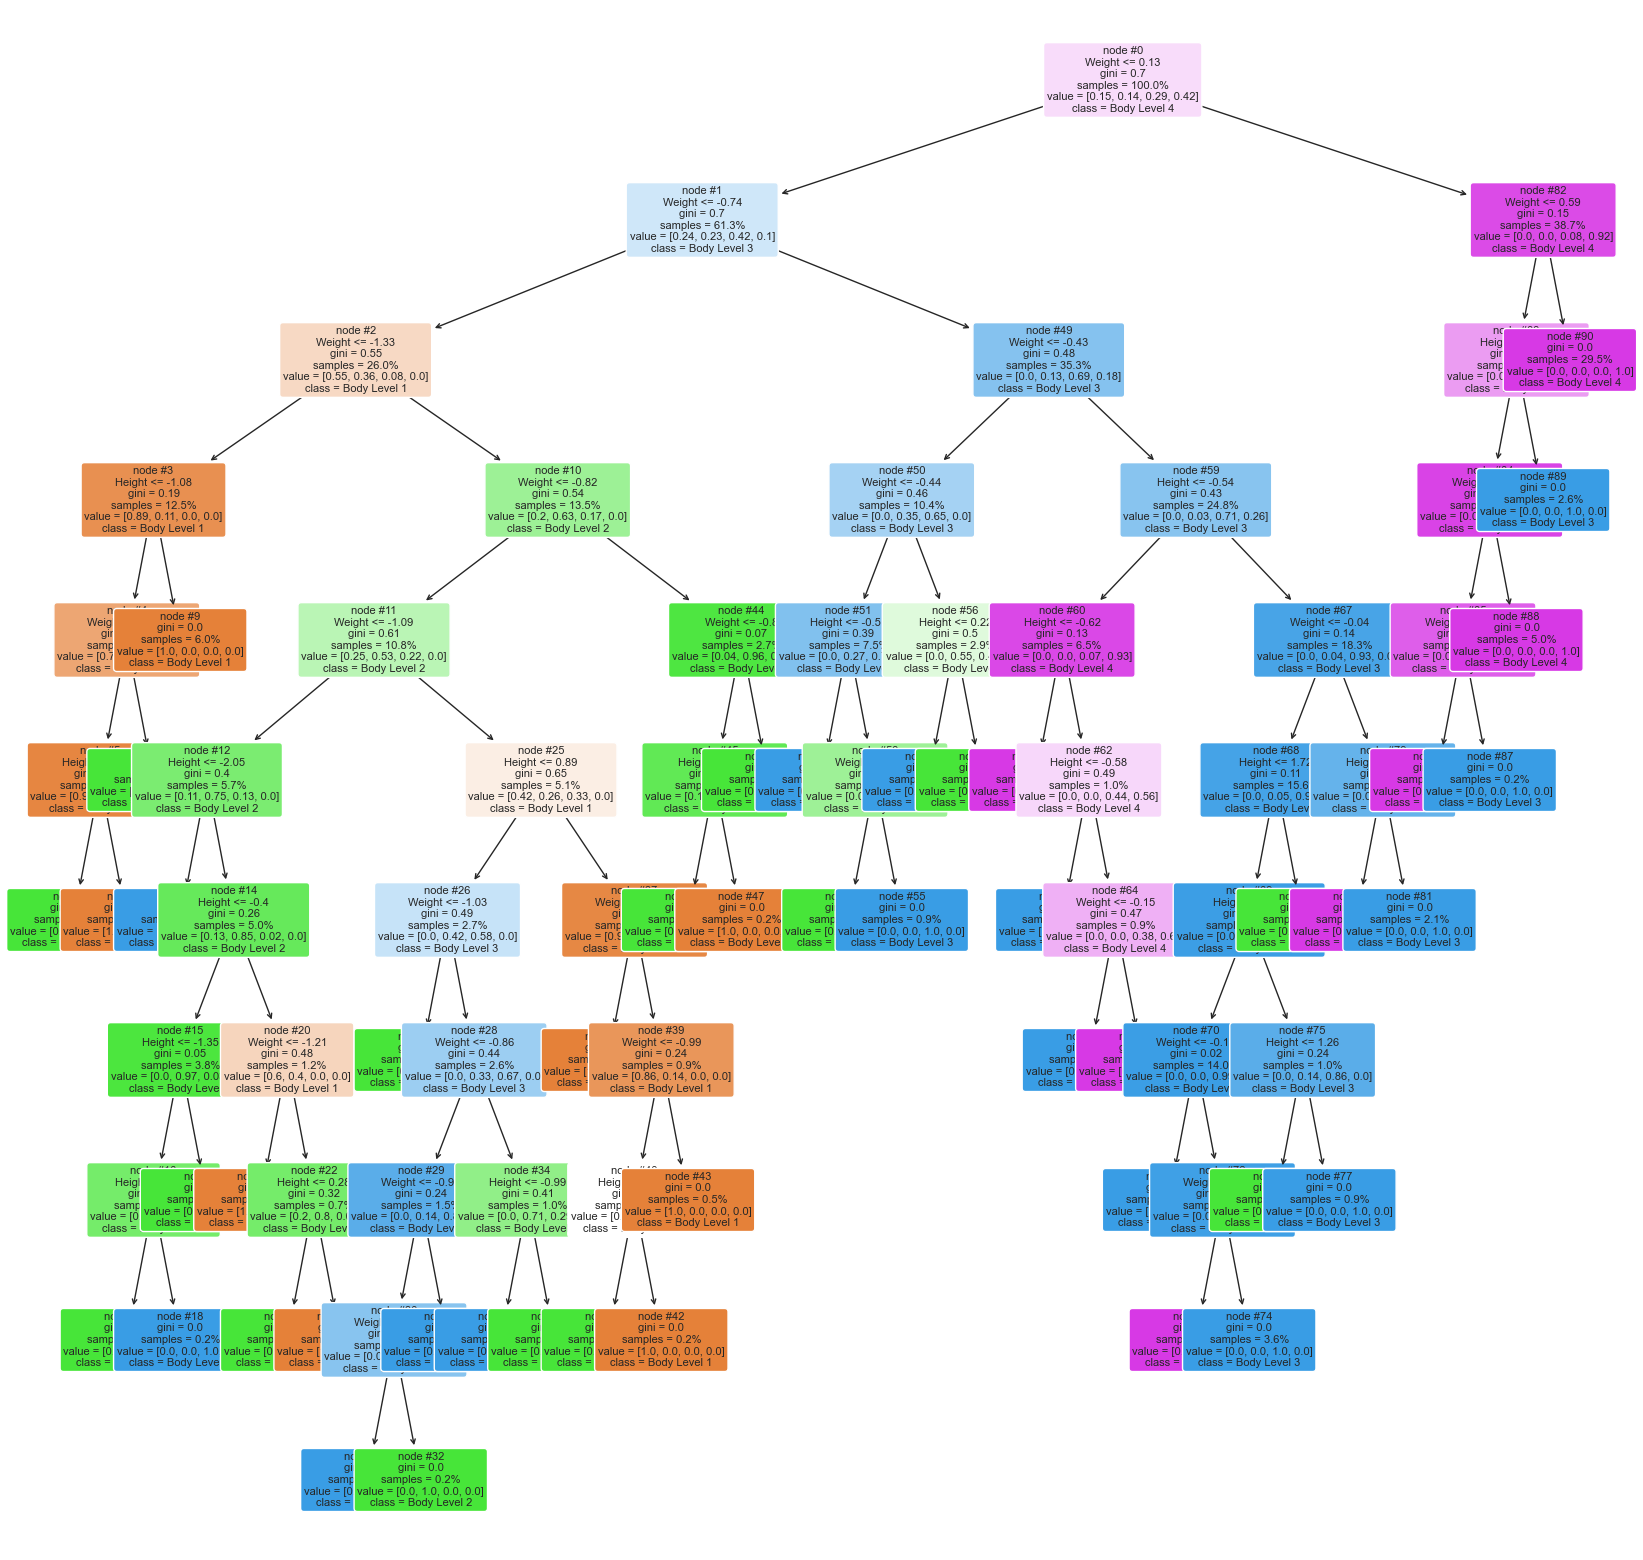

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


# impurity=True shows the impurity measure at each node,
# proportion=False does not show the proportion of samples in each class,
# precision=2 sets the precision of the impurity measure to two decimal places,
# node_ids=True shows the node IDs.
plt.figure(figsize=(20, 20))
plot_tree(clf.estimators_[0], feature_names=X.columns, class_names=['Body Level 1', 'Body Level 2', 'Body Level 3', 'Body Level 4'],
          fontsize=8, impurity=True, rounded=True, proportion=True, precision=2, filled=True, node_ids=True)
plt.savefig(f'../figures/Random Forest/tree_plot.png',
            dpi=300, bbox_inches='tight')
plt.show()
